# 09B. Dynamic programming

### Mingyang Lu

### 3/28/2024

# Dynamic programming

A common optimization problem has a scoring function involving a combination of pairwise terms.

$$E_{tot} = \sum_{i,j}{E_{i,j}} \tag{1}$$
For example, the potential function for a protein structure is commonly modeled by pairwise energy terms. Computing $E_{tot}$ can be done quite efficiently. But due to an extremely large number of configurations for large systems, sampling all possible configurations to find the global optimum becomes infeasible. 

In some special cases, the scoring function can be decomposed into the scoring function of sub-systems. For example, the total score of a system of size $n$ can be computed from the total score of the system of size $n-1$ plus an addition scoring term that is independent to the sub system of size $n-1$.

$$E_{tot}(n) = E_{tot}(n-1) + e(n) \tag{2}$$
In such cases, we can use dynamical programming to find the exact solution of a global extremum. In the following, we will illustrate its usage in sequence alignment.


# Global sequence alignment

We wish to align two sequences for nucleotides or proteins by transforming one sequence into another with replacement, insertion or deletion. For example, for the following two sequences

```
GCATGCG
GATTACA
```

We can align them into 

```
GCATG-CG
G-ATTACA
```

Letters from the same positions can be either a **match** when they are the same, a **mismatch** when they are different, or an indel (insertion or deletion). In the last type of situations, one sequence contains a gap (represented by "-"). We specify scores for each position depending on the matching status. We assign a positive score $S_{match}$ for a match, a negative (or zero) score $S_{mismatch}$ for a mismach, and a negative (or zero) score $g$ for an indel (gap penalty).

As the scoring function involves the comparisons of two sequences in a particular order, the optimum score can be expressed by the optimum score of a sub-system (*i.e.*, sub-string of the sequences). Thus, we can address the optimization problem effectively with dynamic programming. Needleman–Wunsch algorithm is the original method for global sequence alignment (the alignment of the whole sequences).

Consider that the scoring terms for matches and mismatches are provided by the similar matrix $S(A_i,B_j)$ for the position $i$ from the first sequence $A$ and the position $j$ from the second sequence $B$. We can compute the highest score $F_{i,j}$ for the alignment of the first $i$ characters ($i = 0, 1, ... n_A$) in $A$ and the first $j$ characters ($j = 0, 1, ... n_B$) in $B$. 

Thus, 

\begin{equation}
\begin{cases}
  F_{0,j} = jg \tag{3}\\
  F_{i,0} = ig  \\
  F_{i,j} = max(F_{i-1,j-1} + S(A_i, B_j), F_{i,j-1} + g, F_{i-1,j} + g)
\end{cases}
\end{equation}

In the Needleman–Wunsch algorithm, we (1) compute the similarity matrix; (2) compute the matrix of $F_{i,j}$ with Equation (3) recursively; (3) traceback from $F_{n_A,n_B}$ to find the optimal alignment. Note: there might be multiple solutions of the alignment corresponding to the same optimal score. 

In [1]:
import numpy as np

def cal_similarity(A, B, s_match, s_mismatch):
    # A: sequence A
    # B: sequence B
    # s_match: score for a match
    # s_mismatch: score for a mismatch
    # return (s): similarity matrix

    str_a = list(A)
    str_b = list(B)
    nA = len(str_a)
    nB = len(str_b)
    s = np.zeros((nA, nB))
    for i in range(nA):
        for j in range(nB):
            if str_a[i] == str_b[j]:
                s[i,j] = s_match
            else:
                s[i,j] = s_mismatch
    return s

def global_scoring(s, gap):
    # s: matrix of n (length of A), m (length of B)
    # gap: gap penalty score
    # return (f): scores for all possible alignments

    nA, nB = s.shape
    f = np.zeros((nA+1, nB+1))
    f[:,0] = np.arange(nA+1) * gap
    f[0,:] = np.arange(nB+1) * gap
    for i in range(nA):
        for j in range(nB):
            match = f[i,j] + s[i,j]
            delete = f[i,j+1] + gap
            insert = f[i+1,j] + gap
            f[i+1,j+1] = max(match, delete, insert)
    return f

def global_traceback(A, B, f, s, gap):
    # A: sequence A
    # B: sequence B
    # f: score matrix for all possible alignments
    # s: similarity matrix
    # gap: gap penalty
    # return: a vector of two strings indicating the optimal alignment

    str_a = list(A)
    str_b = list(B)
    A_align = ""
    B_align = ""
    AB_match = ""

    i = len(str_a)
    j = len(str_b)
    while i > 0 or j > 0:
        if i > 0 and j > 0 and f[i,j] == f[i-1,j-1] + s[i-1,j-1]:
            A_align = str_a[i-1] + A_align
            B_align = str_b[j-1] + B_align
            if str_a[i-1] == str_b[j-1]:
                AB_match = "|" + AB_match
            else:
                AB_match = " " + AB_match
            i -= 1
            j -= 1
        elif i > 0 and f[i,j] == f[i-1,j] + gap:
            A_align = str_a[i-1] + A_align
            B_align = "-" + B_align
            AB_match = " " + AB_match
            i -= 1
        else:
            A_align = "-" + A_align
            B_align = str_b[j-1] + B_align
            AB_match = " " + AB_match
            j -= 1
    return [A_align, AB_match, B_align]

def global_align(A, B, s_match, s_mismatch, gap):
    # A: sequence A
    # B: sequence B
    # s_match: score for a match
    # s_mismatch: score for a mismatch
    # gap: gap penalty score
    s = cal_similarity(A, B, s_match, s_mismatch)
    f = global_scoring(s, gap)
    print(f)
    results = global_traceback(A, B, f, s, gap)
    return results


In [2]:
s_match = 1
s_mismatch = 0
gap = 0
A = "GAATTCAGTTA"
B = "GGATCGA"
results = global_align(A, B, s_match, s_mismatch, gap)
for r in results:
    print(r)

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 2. 2. 2. 2. 2.]
 [0. 1. 1. 2. 2. 2. 2. 3.]
 [0. 1. 1. 2. 3. 3. 3. 3.]
 [0. 1. 1. 2. 3. 3. 3. 3.]
 [0. 1. 1. 2. 3. 4. 4. 4.]
 [0. 1. 1. 2. 3. 4. 4. 5.]
 [0. 1. 2. 2. 3. 4. 5. 5.]
 [0. 1. 2. 2. 3. 4. 5. 5.]
 [0. 1. 2. 2. 3. 4. 5. 5.]
 [0. 1. 2. 3. 3. 4. 5. 6.]]
GAATTCAGTTA
| | || |  |
GGA-TC-G--A


In [3]:
s_match = 3
s_mismatch = -3
gap = -2
A = "GAATTCAGTTA"
B = "GGATCGA"
results = global_align(A, B, s_match, s_mismatch, gap)
for r in results:
    print(r)


[[  0.  -2.  -4.  -6.  -8. -10. -12. -14.]
 [ -2.   3.   1.  -1.  -3.  -5.  -7.  -9.]
 [ -4.   1.   0.   4.   2.   0.  -2.  -4.]
 [ -6.  -1.  -2.   3.   1.  -1.  -3.   1.]
 [ -8.  -3.  -4.   1.   6.   4.   2.   0.]
 [-10.  -5.  -6.  -1.   4.   3.   1.  -1.]
 [-12.  -7.  -8.  -3.   2.   7.   5.   3.]
 [-14.  -9. -10.  -5.   0.   5.   4.   8.]
 [-16. -11.  -6.  -7.  -2.   3.   8.   6.]
 [-18. -13.  -8.  -9.  -4.   1.   6.   5.]
 [-20. -15. -10. -11.  -6.  -1.   4.   3.]
 [-22. -17. -12.  -7.  -8.  -3.   2.   7.]]
GAATTCAGTTA
| | || |  |
GGA-TC-G--A


# Local sequence alignment

Smith–Waterman algorithm is a local sequence alignment that focuses on the best alignment for partial of the sequences. The method is very similar to global sequence alignment, but the optimum score $H_{i,j}$ 

\begin{equation}
\begin{cases}
  H_{0,j} = 0 \tag{4}\\
  H_{i,0} = 0  \\
  H_{i,j} = max(H_{i-1,j-1} + S(A_i, B_j), H_{i,j-1} + g, H_{i-1,j} + g, 0)
\end{cases}
\end{equation}

Essentially, there is no initial gap penalty, and the optimum scores of negative values are changed to zeros. When tracing back, we start from the $i$ and $j$ pairs from the highest score and stop when $H$ becomes zero. This allows to align only the most significant parts of the two sequences. Again, multiple solutions are possible.

In [4]:
def local_scoring(s, gap):
    # s: matrix of n (length of A), m (length of B)
    # gap: gap penalty score
    # return (h): scores for all possible alignments
    
    nA, nB = s.shape
    h = np.zeros((nA+1, nB+1))
    h[:,0] = 0
    h[0,:] = 0
    for i in range(1, nA+1):
        for j in range(1, nB+1):
            match = h[i-1,j-1] + s[i-1,j-1]
            delete = h[i-1,j] + gap
            insert = h[i,j-1] + gap
            h[i,j] = max(match, delete, insert, 0)
    return h

def local_traceback(A, B, h, s, gap):
    # A: sequence A
    # B: sequence B
    # h: score matrix for all possible alignments
    # s: similarity matrix
    # gap: gap penalty
    # return: a vector of two strings indicating the optimal alignment
    
    str_a = list(A)
    str_b = list(B)
    A_align = ""
    B_align = ""
    AB_match = ""
    
    i, j = np.unravel_index(np.argmax(h, axis=None), h.shape)
    while (i > 0 or j > 0) and h[i,j] > 0:
        if i > 0 and j > 0 and h[i,j] == h[i-1,j-1] + s[i-1,j-1]:
            A_align = str_a[i-1] + A_align
            B_align = str_b[j-1] + B_align
            if str_a[i-1] == str_b[j-1]:
                AB_match = "|" + AB_match
            else:
                AB_match = " " + AB_match
            i -= 1
            j -= 1
        elif i > 0 and h[i,j] == h[i-1,j] + gap:
            A_align = str_a[i-1] + A_align
            B_align = "-" + B_align
            AB_match = " " + AB_match
            i -= 1
        else:
            A_align = "-" + A_align
            B_align = str_b[j-1] + B_align
            AB_match = " " + AB_match
            j -= 1
    return [A_align, AB_match, B_align]

def local_align(A, B, s_match, s_mismatch, gap):
    # A: sequence A
    # B: sequence B
    # s_match: score for a match
    # s_mismatch: score for a mismatch
    # gap: gap penalty score
    s = cal_similarity(A, B, s_match, s_mismatch)
    h = local_scoring(s, gap)
    results = local_traceback(A, B, h, s, gap)
    return results

In [5]:
s_match = 3
s_mismatch = -3
gap = -2
A = "GAATTCAGTTA"
B = "GGATCGA"

# Global alignment
results_global = global_align(A, B, s_match, s_mismatch, gap)
for r in results_global:
    print(r)

# Local alignment
results_local = local_align(A, B, s_match, s_mismatch, gap)
for r in results_local:
    print(r)

[[  0.  -2.  -4.  -6.  -8. -10. -12. -14.]
 [ -2.   3.   1.  -1.  -3.  -5.  -7.  -9.]
 [ -4.   1.   0.   4.   2.   0.  -2.  -4.]
 [ -6.  -1.  -2.   3.   1.  -1.  -3.   1.]
 [ -8.  -3.  -4.   1.   6.   4.   2.   0.]
 [-10.  -5.  -6.  -1.   4.   3.   1.  -1.]
 [-12.  -7.  -8.  -3.   2.   7.   5.   3.]
 [-14.  -9. -10.  -5.   0.   5.   4.   8.]
 [-16. -11.  -6.  -7.  -2.   3.   8.   6.]
 [-18. -13.  -8.  -9.  -4.   1.   6.   5.]
 [-20. -15. -10. -11.  -6.  -1.   4.   3.]
 [-22. -17. -12.  -7.  -8.  -3.   2.   7.]]
GAATTCAGTTA
| | || |  |
GGA-TC-G--A
GAATTC-A
| | || |
G-A-TCGA


# Travelling salesman problem (TSP)

Consider there are $n$ cities represented by the $x$ and $y$ coordinates in 2D. Our goal is to find the shortest route that travels each city exactly once and then return to the distribution center (the first city). 


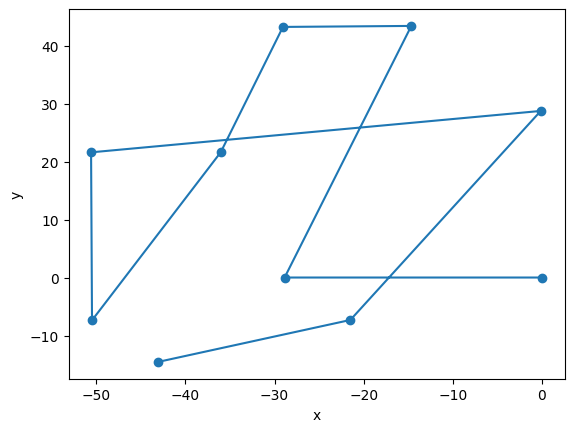

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Read data from file
c10 = pd.read_table("./c10.txt", sep=r"\s+", header=None, names=["x", "y"])

# Plot data
plt.plot(c10["x"], c10["y"], marker="o")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Here, we consider $n = 10$ cities. We can also apply dynamic programming to find the exact solution of the TSP. This method is called Held–Karp algorithm. We formulate the problem as follows.

First, we consider the first city $i=1$ as the starting point, and define a function *tsp_dp* to compute the  distance of the shortests path from $i=1$ to $j=x$ that goes through a list of cities in $z$, $g(x,z)$.

$$g(x, z) = min_{i \in z}(g(i, z|i)+ d(i,x)), \tag{5}$$

where $z|i$ means the list of cities in $z$ excluding city $i$, and $d(i,x)$ is the distance between cities $i$ and $x$. Equation (5) can be applied recursively to eventually compute $g(1, 2:n)$. If the optimal $i$ is saved in each function evaluation, we can trace back to find the order of the cities for the optimal path.  See below for the implementation. 

In [7]:
def tsp_dp(n, d, x, z):
    # n: number of cities
    # d: distance matrix (n by n)
    # x: the last city
    # z: a vector of cities passing through
    # output: g: minimum distance; p: city order
    if len(z) == 0:
        g = d[0][x]
        pos = [0]
    else:
        g = float('inf')
        for i in z:
            z1 = [city for city in z if city != i]
            results_pre = tsp_dp(n, d, i, z1)
            dis = results_pre['g'] + d[i][x]
            if g > dis:
                g = dis
                pos = results_pre['pos'] + [i]
    return {'g': g, 'pos': pos}

This implementation is surprisingly simple. But it only works when $n$ is small (still much better than full permutation).

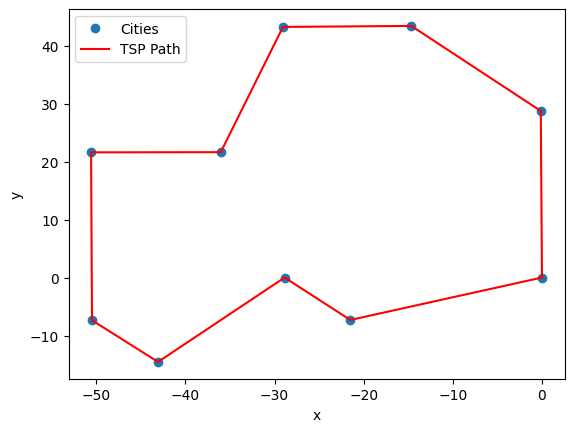

In [8]:
# Calculate distance matrix
d = np.linalg.norm(c10.values[:, None, :] - c10.values, axis=-1)

n = 10
p = tsp_dp(n, d, 0, list(range(1, n)))['pos']

plt.plot(c10['x'], c10['y'], marker='o', linestyle='None', label='Cities')
plt.plot(c10['x'][p], c10['y'][p], marker='', linestyle='-', color='red', label='TSP Path')
plt.plot([c10['x'][p[-1]], c10['x'][p[0]]], [c10['y'][p[-1]], c10['y'][p[0]]], linestyle='-', color='red')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()